# 7/11 + 7/12: Logistic Regression - Multi-class classification of AQI category

In [11]:
#import libraries
import pandas as pd
import numpy as np
import regex as re
import datetime
import timeit

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc, 
classification_report, hamming_loss, mean_absolute_error)

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

%matplotlib inline

# Load in data

In [12]:
def get_data(filename):
    #print(type(filename), filename)
    
    #1. read in data
    data = pd.read_csv(filename)
    #print(data.shape)
    
    #2. drop null index col, null rows where date does not exist in month
    data.drop(['Unnamed: 0'], axis=1, inplace = True)
    data = data[data['state code'].isnull() == False]
    #print(data.shape)
    
    #3. convert data columns to desired type
    data['issue date'] = pd.to_datetime(data['issue date'])
    data['valid date'] = pd.to_datetime(data['valid date'])
    
    data['record sequence'] = data['record sequence'].astype('int64')
    data['action day']=[True if day == 'Yes' else False for day in data['action day']]    #no missing values
    
    data['urldate'] = pd.to_datetime(data['urldate'])
    #print(data.dtypes)
    
    #4. create calculated data column: feature
    data['categorical'] = [1 if (cat == 'Good' or cat == 'Moderate') else 0 for cat in data['AQI category']]
    #print(data.shape)
    
    return(data)

In [13]:
data = get_data('../Data/data.csv')

In [14]:
data.shape

(1946051, 19)

In [15]:
#relevant data function has changed to now filter for:
    #data type = 'F', for Forecast
    #state = 'CA', rather than reporting area
    #and drop duplicates per reporting area per valid date

def relevant_data(datadf, state):
    datadf = datadf[datadf['data type'] == 'F']
    datadf = datadf[datadf['state code'] == state]
    datadf.drop_duplicates(['valid date', 'reporting area'], keep = 'first', inplace = True)
    return (datadf)

In [16]:
cadata = relevant_data(data, 'CA')
cadata.shape

(51845, 19)

In [17]:
#using EPA valid date forecast data --> more realistic as predictor of what to AQI to expect the next day
cadata.head()

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,longitude,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical
74,2017-05-31,2017-06-01,NaN,PDT,1,F,Y,Antelope Vly,CA,34.6694,-118.1305,OZONE,67.0,Moderate,False,NaN,Antelope Valley AQMD,1970-01-01 00:00:00.020170601,1
82,2017-06-01,2017-06-02,NaN,PDT,1,F,Y,Antelope Vly,CA,34.6694,-118.1305,OZONE,46.0,Good,False,NaN,Antelope Valley AQMD,1970-01-01 00:00:00.020170601,1
89,2017-05-31,2017-06-01,NaN,PDT,1,F,Y,Anza Vly,CA,33.5603,-116.7659,PM2.5,55.0,Moderate,False,NaN,South Coast AQMD,1970-01-01 00:00:00.020170601,1
96,2017-06-01,2017-06-02,NaN,PDT,1,F,Y,Anza Vly,CA,33.5603,-116.7659,PM2.5,57.0,Moderate,False,NaN,South Coast AQMD,1970-01-01 00:00:00.020170601,1
128,2017-06-01,2017-06-01,NaN,PDT,0,F,Y,Arden Arcade-Del Paso Manor,CA,38.6138,-121.3680,OZONE,51.0,Moderate,False,"Thursday, light to moderate southwesterly wind...",Sacramento Metro. AQMD,1970-01-01 00:00:00.020170601,1


In [19]:
list(cadata['AQI category'].unique())

['Moderate',
 'Good',
 'Unhealthy for Sensitive Groups',
 'Unhealthy',
 'Very Unhealthy']

In [20]:
#Create distance between reporting area lat / long and SF area lat / long
    #convert to gdf to calculate

def distance(datadf, state = 'CA', reparea = 'San Francisco'):
    
    #dropping state-specific reporting areas with null lat / long in CA
    if state == 'CA':
        #print(datadf.shape)
        datadf = datadf[datadf['reporting area'] != 'TestA']
        datadf = datadf[datadf['reporting area'] != 'TestC']
        #print(datadf.shape)

    #set up gdf
    geometry = [Point(xy) for xy in zip(datadf['longitude'], datadf['latitude'])]
    #print(len(geometry))

    crs = {'init' :'epsg:4326'}
    gdf = gpd.GeoDataFrame(datadf, crs = crs, geometry = geometry)
    #print(gdf.shape)
    #display(gdf.head(5))
    
    #set up distance
    gdf['desiredarea_geometry'] = gdf[gdf['reporting area'] == reparea]['geometry'].values[0]
    desiredarea_geometry = gdf[gdf['reporting area'] == reparea]['geometry'].values[0]
    
    distance = gdf['geometry'].distance(desiredarea_geometry)
    gdf['distance'] = distance
    datadf['distance'] = distance    #set in both geopandas and pandas dfs
    #display(datadf.head(5))
    
    return(datadf)

In [21]:
print(distance(cadata).shape, cadata.shape)    #checking same data, with 2 new cols added

#reset cadata to new df
cadata = distance(cadata)
print(cadata.shape)

(51841, 21) (51845, 19)
(51841, 21)


In [22]:
#Importing predictors to limit data to closest n reporting areas for faster + more relevant modeling
    #distance also serves as a new feature
    
#Using distance as weight
def predictors(n, datadf, reparea = 'San Francisco'):
    #modified from Geo-spatial nb: sort by unique reporting area by distance
        #maintain original datadf values
    predictor_areas = datadf.drop_duplicates(['reporting area'], keep = 'first', inplace = False)    
    #print(predictor_areas.shape)
    
    predictor_areas = predictor_areas.sort_values(['distance']).head(n+1)    
    predictor_areas = predictor_areas[predictor_areas['reporting area'] != reparea]
    #print(predictor_areas.shape)

    #assign inverse weight based on distance in predictor df
    weight = [i/sum(predictor_areas['distance']) for i in predictor_areas['distance']]
    predictor_areas['weight'] = weight[::-1]
    
    return (predictor_areas)

In [23]:
pred = predictors(3, cadata)
pred

,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,...,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical,geometry,distance,weight
3142,2017-06-01,2017-06-01,NaN,PDT,0,F,Y,Oakland,CA,37.80,...,36.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631,0.457669
3954,2017-06-01,2017-06-01,NaN,PDT,0,F,Y,San Rafael,CA,37.97,...,35.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.52 37.97),0.237697,0.318041
3619,2017-06-01,2017-06-01,NaN,PDT,0,F,Y,Redwood City,CA,37.48,...,39.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.22 37.48),0.342053,0.224291


In [24]:
areas = list(pred['reporting area'])
areas

['Oakland', 'San Rafael', 'Redwood City']

In [25]:
cadata3 = cadata[cadata['reporting area'].isin(areas)]
print(cadata3.shape)
print(cadata3['AQI category'].unique())
display(cadata3.head())

(1200, 21)
['Good' 'Moderate' 'Unhealthy for Sensitive Groups']


,issue date,valid date,valid time,time zone,record sequence,data type,primary,reporting area,state code,latitude,...,pollutant,AQI value,AQI category,action day,discussion,forecast source,urldate,categorical,geometry,distance
3142,2017-06-01,2017-06-01,NaN,PDT,0,F,Y,Oakland,CA,37.8,...,OZONE,36.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631
3143,2017-06-01,2017-06-02,NaN,PDT,1,F,Y,Oakland,CA,37.8,...,OZONE,41.0,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631
3144,2017-06-01,2017-06-03,NaN,PDT,2,F,Y,Oakland,CA,37.8,...,OZONE,NaN,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631
3145,2017-06-01,2017-06-04,NaN,PDT,3,F,Y,Oakland,CA,37.8,...,OZONE,NaN,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631
3146,2017-06-01,2017-06-05,NaN,PDT,4,F,Y,Oakland,CA,37.8,...,OZONE,NaN,Good,False,NaN,San Francisco Bay Area AQMD,1970-01-01 00:00:00.020170601,1,POINT (-122.27 37.8),0.167631


In [26]:
#1. Preprocessing
    #a. Set X variable set and y target
        #convert AQI category into ordinal values for y target
    #b. Split data into train and test sets, stratifying for AQI category
        #dataset is mostly descriptive so pulling out a few features
        #takes in other reporting areas in CA to predict for SF

#a.
X = cadata3.drop(['AQI category', 'AQI value'], axis = 1)

def aqicat(df):
    aqicats = []
    for cat in df['AQI category']:
        #print(cat)
        if cat == 'Good':
            aqicats.append(0)
        elif cat == 'Moderate':
            aqicats.append(50)
        elif cat == 'Unhealthy for Sensitive Groups':
            aqicats.append(100)
        elif cat == 'Unhealthy':
            aqicats.append(150)
        elif cat == 'Very Unhealthy':
            aqicats.append(200)
        elif cat == 'Hazardous':
            aqicats.append(300)
        else:
            aqicats.append(404)
    return (aqicats)

cadata3['aqicat'] = aqicat(cadata3)
y = cadata3['aqicat']

print(X.shape, y.shape)

(1200, 19) (1200,)


In [27]:
#b. 
#tried stratifying y: returned error
    #ValueError: The least populated class in y has only 1 member, which is too few. 
    #The minimum number of groups for any class cannot be less than 2.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)    

print('Train:', X_train.shape, y_train.shape, '\n', 'Test:', X_test.shape, y_test.shape)

Train: (900, 19) (900,) 
 Test: (300, 19) (300,)


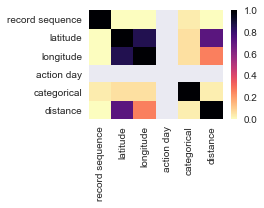

In [28]:
#2. Determine existing features to use in model from X_train data
    #look at correlation matrix

fig = plt.figure(figsize=(3, 2))
sns.heatmap(abs(X.corr()), cmap='magma_r');

In [29]:
#try 4 existing features: primary, pollutant, action day, forecast source
#print(X_train.shape)
#display(X_train.head())
list(X_train.columns)

['issue date',
 'valid date',
 'valid time',
 'time zone',
 'record sequence',
 'data type',
 'primary',
 'reporting area',
 'state code',
 'latitude',
 'longitude',
 'pollutant',
 'action day',
 'discussion',
 'forecast source',
 'urldate',
 'categorical',
 'geometry',
 'distance']

In [36]:
#dummy categorical columns
X_train_existing = pd.get_dummies(X_train[['primary', 'pollutant', 'action day', 'forecast source']], drop_first = False)

X_train_existing.head()

,action day,primary_Y,pollutant_OZONE,pollutant_PM2.5,forecast source_San Francisco Bay Area AQMD
1327968,False,1,1,0,1
1562515,False,1,1,0,1
361327,False,1,0,1,1
1933408,False,1,1,0,1
1074102,False,1,0,1,1


In [37]:
#3. Determine new features to use in model from X_train data
    #categorical features

#create 3 new features: Season, Red flag text in discussion, categ: if Reporting area is NorCal or SoCal

#Season

def season(df):
    seasons = []
    for month in df['valid date'].dt.month:
        if month in [12, 1, 2]:
            seasons.append('Winter')
        elif month in [3, 4, 5]:
            seasons.append('Spring')
        elif month in [6, 7, 8]:
            seasons.append('Summer')
        elif month in [9, 10, 11]:
            seasons.append('Fall')
        else:
            seasons.append(np.NaN)
    return (seasons)

X_train['season'] = season(X_train)

In [38]:
X_train['season'].head()

1327968    Spring
1562515    Spring
361327     Summer
1933408    Summer
1074102    Winter
Name: season, dtype: object

In [204]:
#Next steps: NLP - did not include in new feature set below

#Discussion text: Fire
#for i, text in enumerate(list(X_train[X_train['discussion'].isna() == False]['discussion'].values)):
    #print(i)
    #print(list(X_train[X_train['discussion'].isna() == False]['discussion'].values)[i])
    #print('\n')


In [39]:
#RepArea: NorCal v SoCal
    #dividing line lat/long = (36.4, -119.4)
    #sources
        #https://en.wikipedia.org/wiki/Southern_California#/media/File:Southern_California_counties_in_red.png
        #https://lifehacker.com/5943091/answer-northern-vs-southern-california


def divide(df):
    divider = []
    for i, index in enumerate(df.index):
        #print(i, index)
        divider_lat = 36.4
        lat = df.iloc[i:i+1,:]['latitude'].values[0]
        if lat > divider_lat:
            divider.append('Norcal')
        elif lat < divider_lat:
            divider.append('Socal')
        elif lat == divider_lat:
            divider.append('Neither')
        else:
            divider.append(np.NaN)
    return (divider)

X_train['divider'] = divide(X_train)

In [40]:
X_train['divider'].head()

1327968    Norcal
1562515    Norcal
361327     Norcal
1933408    Norcal
1074102    Norcal
Name: divider, dtype: object

In [41]:
#dummy new categorical columns
X_train_new = pd.get_dummies(X_train[['season', 'divider']], drop_first = False)
X_train_new.head()

,season_Fall,season_Spring,season_Summer,season_Winter,divider_Norcal
1327968,0,1,0,0,1
1562515,0,1,0,0,1
361327,0,0,1,0,1
1933408,0,0,1,0,1
1074102,0,0,0,1,1


In [42]:
#join existing and new X_train dfs together
X_train = pd.concat([X_train_existing, X_train_new], axis = 1)

In [43]:
#4. Perform similar transformations on X_test data
#existing variables
X_test_existing = pd.get_dummies(X_test[['primary', 'pollutant', 'action day', 'forecast source']], drop_first = False)
X_test_existing.head()

,action day,primary_Y,pollutant_OZONE,pollutant_PM2.5,forecast source_San Francisco Bay Area AQMD
1908491,False,1,1,0,1
1360507,False,1,1,0,1
144371,False,1,1,0,1
734035,False,1,0,1,1
73487,False,1,1,0,1


In [44]:
#new variables
X_test['season'] = season(X_test)
X_test['divider'] = divide(X_test)
X_test_new = pd.get_dummies(X_test[['season', 'divider']], drop_first = False)
X_test_new.head()

,season_Fall,season_Spring,season_Summer,season_Winter,divider_Norcal
1908491,0,0,1,0,1
1360507,0,1,0,0,1
144371,0,0,1,0,1
734035,1,0,0,0,1
73487,0,0,1,0,1


In [45]:
#join existing and new X_test dfs together
X_test = pd.concat([X_test_existing, X_test_new], axis = 1)
X_test.head()

,action day,primary_Y,pollutant_OZONE,pollutant_PM2.5,forecast source_San Francisco Bay Area AQMD,season_Fall,season_Spring,season_Summer,season_Winter,divider_Norcal
1908491,False,1,1,0,1,0,0,1,0,1
1360507,False,1,1,0,1,0,1,0,0,1
144371,False,1,1,0,1,0,0,1,0,1
734035,False,1,0,1,1,1,0,0,0,1
73487,False,1,1,0,1,0,0,1,0,1


In [46]:
print(X_train.shape, X_test.shape)

(900, 10) (300, 10)


In [47]:
#align train and test sets: more applicable to larger n comparisons
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

print(X_train.shape, X_test.shape)

(900, 10) (300, 10)


In [48]:
#5. Use pipeline to prepare data
    #a. Scale numeric data --> Q: is this necessary given categorical dummy features?
    #b. Instantiate and fit logreg model
    #c. GridSearchCV for best params, cross-val
    #d. Regularize with Ridge or Lasso function

pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

In [52]:
params = {'lr__penalty': ['l1','l2'],
          'lr__C': np.linspace(1, 10)
         }

gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

print('Train model fit: ', gs.score(X_train, y_train))
print('Test model fit: ', gs.score(X_test, y_test))

print('GS best Accuracy score:', gs.best_score_)
print('GS best params:', gs.best_params_)
print('')

Train model fit:  0.7111111111111111
Test model fit:  0.6766666666666666
GS best Accuracy score: 0.7066666666666667
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}



In [45]:
#multiple scoring methods
scoring = {'Accuracy_score': 'accuracy',
           #does not apply to multilabel classification: 'Average_precision_score': 'average_precision', 
           #does not apply to multilabel classification: 'F1_samples_score': 'f1_samples', 
           'Explained_variance_score': 'explained_variance', #
           'Mean_absolute_error': 'neg_mean_absolute_error',
           'R2_score': 'r2'
          }

for score in scoring.keys():
    print(score)
    gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring=scoring[score])
    gs.fit(X_train, y_train)

    print('Train model fit: ', gs.score(X_train, y_train))
    print('Test model fit: ', gs.score(X_test, y_test))
    
    print('GS best '+str(score)+' :', gs.best_score_)
    print('GS best params:', gs.best_params_)
    print('\n')

Accuracy_score


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train model fit:  0.7115165336374002
Test model fit:  0.6723549488054608
GS best Accuracy_score : 0.7115165336374002
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Explained_variance_score


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train model fit:  -0.10897477256597177
Test model fit:  -0.13842355845529886
GS best Explained_variance_score : -0.10360198371629352
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Mean_absolute_error


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train model fit:  -14.424173318129988
Test model fit:  -16.38225255972696
GS best Mean_absolute_error : -14.424173318129988
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


R2_score


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train model fit:  -0.19298556896143837
Test model fit:  -0.2399929465702697
GS best R2_score : -0.1906248904062757
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}




In [106]:
#additional metrics: classification_report, hamming_loss

pred_train = gs.predict(X_train)
pred_test = gs.predict(X_test)

print('Classification_report')    #returns text summary of precision, recall, F1 score for each class
print('Train:', classification_report(y_train, pred_train))
print('Test:', classification_report(y_test, pred_test))

print('Hamming_loss')    #returns the fraction of incorrectly predicted labels
print('Train:', hamming_loss(y_train, pred_train))
print('Test:', hamming_loss(y_test, pred_test))

Classification_report
Train:              precision    recall  f1-score   support

          0       0.84      0.65      0.73       319
         50       0.66      0.85      0.74       261
        100       0.00      0.00      0.00         5

avg / total       0.75      0.74      0.73       585

Test:              precision    recall  f1-score   support

          0       0.77      0.56      0.65       104
         50       0.60      0.81      0.69        89
        100       0.00      0.00      0.00         2

avg / total       0.69      0.67      0.66       195

Hamming_loss
Train: 0.26495726495726496
Test: 0.3333333333333333


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train ROC AUC: 0.0029578641801548677
Train confusion matrix:


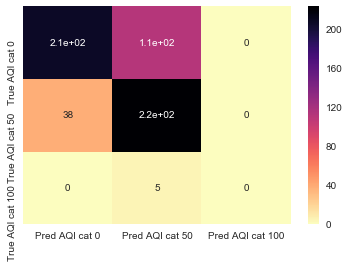

In [121]:
#6. Evaluation pt1
    #confusion matrix

print('Train ROC AUC:', gs.score(X_train, y_train))
print('Train confusion matrix:')

sns.heatmap(confusion_matrix(y_train, pred_train), annot=True, cmap='magma_r', 
            xticklabels=['Pred AQI cat 0', 'Pred AQI cat 50', 'Pred AQI cat 100'], 
            yticklabels=['True AQI cat 0', 'True AQI cat 50', 'True AQI cat 100']);


Test ROC AUC: -0.23465809468147336
Test confusion matrix:


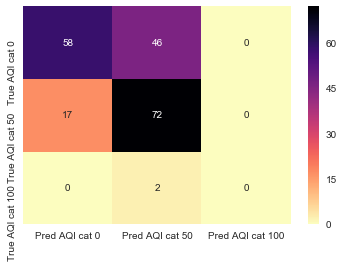

In [122]:
print('Test ROC AUC:', gs.score(X_test, y_test))
print('Test confusion matrix:')

sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, cmap='magma_r', 
            xticklabels=['Pred AQI cat 0', 'Pred AQI cat 50', 'Pred AQI cat 100'], 
            yticklabels=['True AQI cat 0', 'True AQI cat 50', 'True AQI cat 100']);


In [48]:
#7. Evaluation pt2
    #mean absolute error
    
#predicted results: pred_train, pred_test
#actual results: y_train, y_test

mae_train = np.round(mean_absolute_error(y_train, pred_train), 2)
mae_test = np.round(mean_absolute_error(y_test, pred_test), 2)
print('Train MAE:', mae_train, '\n', 'Test MAE:', mae_test)

Train MAE: 14.42 
 Test MAE: 16.38


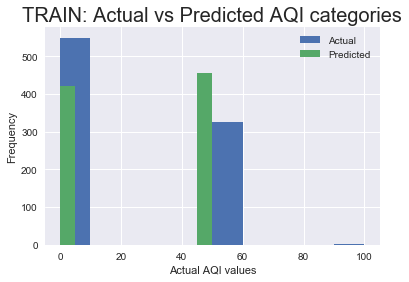

In [49]:
#8. Plot results
fig, ax = plt.subplots()

pred_train = pd.Series(pred_train)

plt.title('TRAIN: Actual vs Predicted AQI categories', fontsize = 20)
plt.xlabel('Actual AQI values')
y_train.plot(kind = 'hist', ax = ax, label = 'Actual')
pred_train.plot(kind = 'hist', ax = ax, label = 'Predicted')
plt.legend()
plt.show()

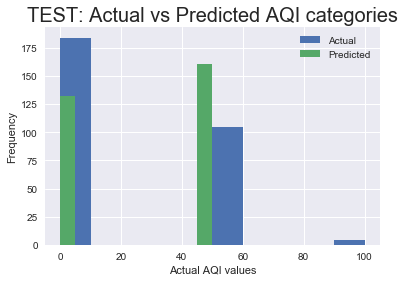

In [50]:
fig, ax = plt.subplots()

pred_test = pd.Series(pred_test)

plt.title('TEST: Actual vs Predicted AQI categories', fontsize = 20)
plt.xlabel('Actual AQI values')
y_test.plot(kind = 'hist', ax = ax, label = 'Actual')
pred_test.plot(kind = 'hist', ax = ax, label = 'Predicted')
plt.legend()
plt.show()

# Iterate over various n closest reporting areas

In [83]:
def set_xy(n, datadf, state = 'CA', reparea = 'San Francisco'):
    #return relevant data using previously defined functions
    statedata = relevant_data(datadf, state)
    
    statedata = distance(statedata, state = state, reparea = reparea)
    pred = predictors(n, statedata)
    
    areas = list(pred['reporting area'])
    statedata_n = statedata[statedata['reporting area'].isin(areas)]
    #print(statedata_n.shape)
    
    #set X and y
    X = statedata_n.drop(['AQI category', 'AQI value'], axis = 1)
    statedata_n['aqicat'] = aqicat(statedata_n)
    y = statedata_n['aqicat']
    
    print('Returns list with X as elem0 nand y as elem1', '\n',
          'X shape:', X.shape,'\n',
          'y shape:', y.shape)
    
    return (X, y)

In [84]:
X, y = set_xy(2, data, 'CA')

Returns list with X as elem0 nand y as elem1 
 X shape: (780, 19) 
 y shape: (780,)


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [101]:
def transform_features(X, y):
    #train-test-split X, y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)    
    print('Original feature set:', '\n', 'Train:', X_train.shape, y_train.shape, '\n', 'Test:', X_test.shape, y_test.shape)
    
    #wrangle train and test features
    dfs = [X_train, X_test]
    
    for i, df in enumerate(dfs):
        df_existing = pd.get_dummies(df[['primary', 'pollutant', 'action day', 'forecast source']], drop_first = False)
        df['season'] = season(df)
        df['divider'] = divide(df)
        df_new = pd.get_dummies(df[['season', 'divider']], drop_first = False)
        df = pd.concat([df_existing, df_new], axis = 1)
        #print(i, i.shape)
        dfs[i] = df
    
    X_train, X_test = dfs[0].align(dfs[1], join='outer', axis=1, fill_value=0)
    print('Transformed feature set:', '\n', 'Train:', X_train.shape, y_train.shape, '\n', 'Test:', X_test.shape, y_test.shape)
    
    return (X_train, X_test, y_train, y_test)

In [102]:
X_train, X_test, y_train, y_test = transform_features(X, y)

Original feature set: 
 Train: (585, 19) (585,) 
 Test: (195, 19) (195,)


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Transformed feature set: 
 Train: (585, 10) (585,) 
 Test: (195, 10) (195,)


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [114]:
#coloring text for readability
    #source: https://stackoverflow.com/questions/287871/print-in-terminal-with-colors

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

print(bcolors.BOLD + bcolors.HEADER + str('Model Results Summary').upper() + bcolors.ENDC + bcolors.ENDC)

Test
MODEL RESULTS SUMMARY


In [136]:
#prints results, returns model

def run_model(X_train, X_test, y_train, y_test):
    
    print(bcolors.BOLD + bcolors.HEADER + str('Model Results Summary').upper() + bcolors.ENDC + bcolors.ENDC)
    print('\n')
    
    #instantiate model
    pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
    ])

    params = {'lr__penalty': ['l1','l2'],
              'lr__C': np.linspace(1, 10)
             }

    scoring = {'Accuracy_score': 'accuracy',
               'Explained_variance_score': 'explained_variance', 
               'Mean_absolute_error': 'neg_mean_absolute_error',
               'R2_score': 'r2'
              }

    for score in scoring.keys():
        print(score)

        #run model
        gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring=scoring[score])
        gs.fit(X_train, y_train)

        print('Train model fit: ', gs.score(X_train, y_train))
        print('Test model fit: ', gs.score(X_test, y_test))

        print('GS best '+str(score)+' :', gs.best_score_)
        print('GS best params:', gs.best_params_)
        print('\n')

    #evaluate model
        ## Additional metrics
    pred_train = gs.predict(X_train)
    pred_test = gs.predict(X_test)

    print('Classification_report')    #returns text summary of precision, recall, F1 score for each class
    print('Train:', classification_report(y_train, pred_train))
    print('Test:', classification_report(y_test, pred_test))

    print('Hamming_loss')    #returns the fraction of incorrectly predicted labels
    print('Train:', hamming_loss(y_train, pred_train))
    print('Test:', hamming_loss(y_test, pred_test))
    
    return (gs)

In [120]:
model3 = run_model(X_train, X_test, y_train, y_test)

MODEL RESULTS SUMMARY


Accuracy_score
Train model fit:  0.7350427350427351
Test model fit:  0.6666666666666666
GS best Accuracy_score : 0.7350427350427351
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Explained_variance_score
Train model fit:  0.05530876143560881
Test model fit:  -0.1636469900642903
GS best Explained_variance_score : 0.057241736123367144
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Mean_absolute_error
Train model fit:  -13.247863247863247
Test model fit:  -16.666666666666668
GS best Mean_absolute_error : -13.247863247863247
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


R2_score
Train model fit:  0.0029578641801548677
Test model fit:  -0.23465809468147336
GS best R2_score : 0.002915222565876342
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Classification_report
Train:              precision    recall  f1-score   support

          0       0.84      0.65      0.73       319
         50       0.66      0.85      0.74       261
        100

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [169]:
#prints plots, no return

def plot_model(model, X_train, X_test, y_train, y_test):
    
    #predict target category
    pred_train = pd.Series(gs.predict(X_train))
    pred_test = pd.Series(gs.predict(X_test))
    
    #plot for train and test sets
    name = ['Train', 'Test']
    X = [X_train, X_test]
    y = [y_train, y_test]
    pred = [pred_train, pred_test]
    
    for i, j in enumerate(X):
        #print(i, type(j))
        
        if i == 0:
            print('X_train shape:', j.shape)
        elif i == 1:
            print('X_test shape:', j.shape)
        else:
            print('Check function')
    
        # confusion matrix
        print(' ROC AUC:', gs.score(X[i],y[i]))
        ax = sns.heatmap(confusion_matrix(y[i], pred[i]), annot=True, cmap='magma_r', 
                    xticklabels=['Pred AQI cat 0', 'Pred AQI cat 50', 'Pred AQI cat 100'], 
                    yticklabels=['True AQI cat 0', 'True AQI cat 50', 'True AQI cat 100']);
        ax.set_title(name[i]+' confusion matrix:', fontsize = 20)

        # bar chart
        fig, ax = plt.subplots()
        plt.title(name[i]+' Actual vs Predicted AQI categories', fontsize = 20)
        plt.xlabel('Actual AQI values')
        y[i].plot(kind = 'hist', ax = ax, label = 'Actual')
        pred[i].plot(kind = 'hist', ax = ax, label = 'Predicted')
        plt.legend()
        plt.show()

X_train shape: (585, 10)
 ROC AUC: 0.0029578641801548677


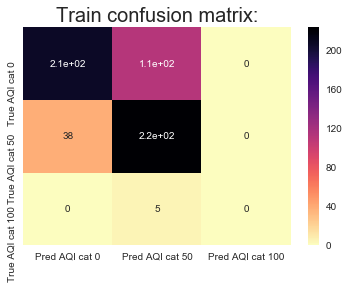

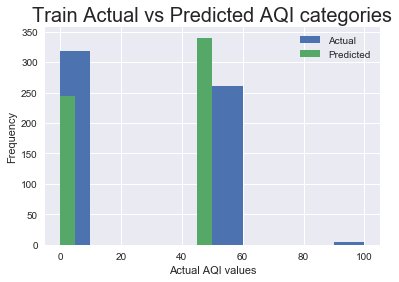

X_test shape: (195, 10)
 ROC AUC: -0.23465809468147336


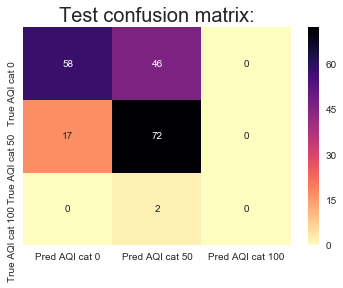

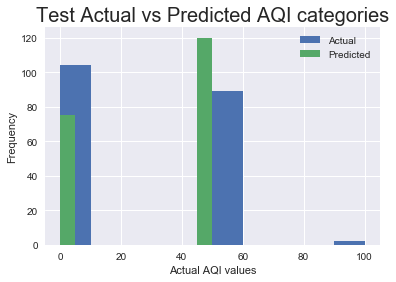

In [170]:
plot_model(model3, X_train, X_test, y_train, y_test)

In [8]:
#prints results, no return

repareas = [1, 3, 5]
def n_closestareas(repareas, state = 'CA', reparea = 'San Francisco'):
    for n in repareas:
        print(bcolors.OKBLUE + bcolors.BOLD + bcolors.UNDERLINE + 
            str('For '+str(n)+' closest reporting areas').upper()
             + bcolors.ENDC)
        print('\n')
        #print(n)
        X, y = set_xy(n, data, state, reparea)
        print('\n')
        X_train, X_test, y_train, y_test = transform_features(X, y)
        print('\n')
        model = run_model(X_train, X_test, y_train, y_test)
        print('\n')
        plot_model(model, X_train, X_test, y_train, y_test)
        print('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')

In [9]:
print(repareas)

[1, 3, 5]


In [10]:
warnings.filterwarnings('ignore')

FOR 1 CLOSEST REPORTING AREAS


Returns list with X as elem0 nand y as elem1 
 X shape: (390, 19) 
 y shape: (390,)


Original feature set: 
 Train: (292, 19) (292,) 
 Test: (98, 19) (98,)
Transformed feature set: 
 Train: (292, 10) (292,) 
 Test: (98, 10) (98,)


MODEL RESULTS SUMMARY


Accuracy_score
Train model fit:  0.7226027397260274
Test model fit:  0.6836734693877551
GS best Accuracy_score : 0.7226027397260274
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Explained_variance_score
Train model fit:  -0.0319703622392975
Test model fit:  -0.06509104998062787
GS best Explained_variance_score : -0.026738676518380845
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Mean_absolute_error
Train model fit:  -13.86986301369863
Test model fit:  -15.816326530612244
GS best Mean_absolute_error : -13.86986301369863
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


R2_score
Train model fit:  -0.08177826564215152
Test model fit:  -0.1770631538163503
GS best R2_score : -0.084555899

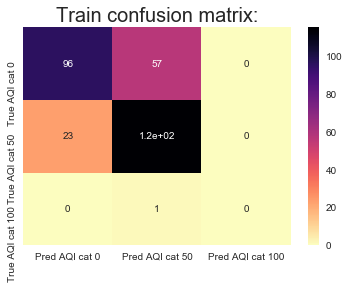

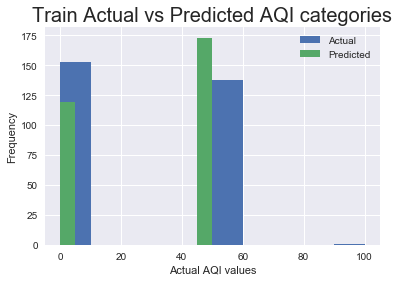

X_test shape: (98, 10)
 ROC AUC: -0.1770631538163503


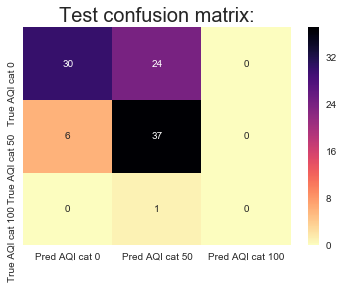

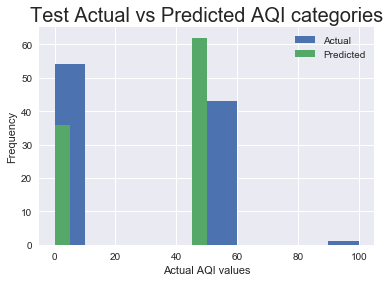


















FOR 3 CLOSEST REPORTING AREAS


Returns list with X as elem0 nand y as elem1 
 X shape: (1170, 19) 
 y shape: (1170,)


Original feature set: 
 Train: (877, 19) (877,) 
 Test: (293, 19) (293,)
Transformed feature set: 
 Train: (877, 10) (877,) 
 Test: (293, 10) (293,)


MODEL RESULTS SUMMARY


Accuracy_score
Train model fit:  0.7115165336374002
Test model fit:  0.6723549488054608
GS best Accuracy_score : 0.7115165336374002
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Explained_variance_score
Train model fit:  -0.10897477256597177
Test model fit:  -0.13842355845529886
GS best Explained_variance_score : -0.10360198371629352
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Mean_absolute_error
Train model fit:  -14.424173318129988
Test model fit:  -16.38225255972696
GS best Mean_absolute_error : -14.424173318129988
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


R2_score
Train model fit:  -0.19298556896143837
Test model fit:  -0.2399929465702697
GS best

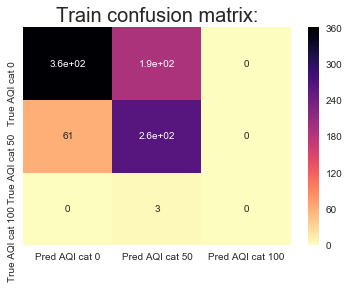

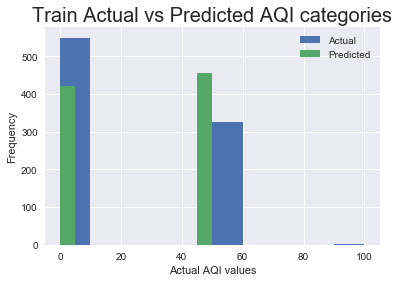

X_test shape: (293, 10)
 ROC AUC: -0.2399929465702697


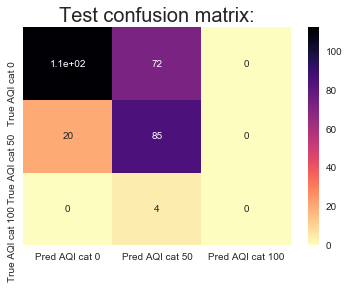

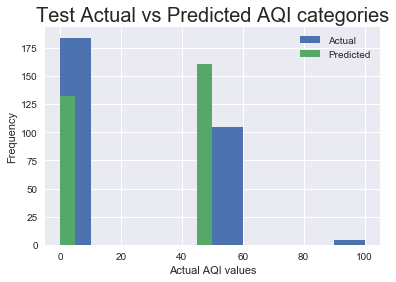


















FOR 5 CLOSEST REPORTING AREAS


Returns list with X as elem0 nand y as elem1 
 X shape: (1950, 19) 
 y shape: (1950,)


Original feature set: 
 Train: (1462, 19) (1462,) 
 Test: (488, 19) (488,)
Transformed feature set: 
 Train: (1462, 10) (1462,) 
 Test: (488, 10) (488,)


MODEL RESULTS SUMMARY


Accuracy_score
Train model fit:  0.6839945280437757
Test model fit:  0.6557377049180327
GS best Accuracy_score : 0.6703146374829001
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Explained_variance_score
Train model fit:  -0.2892631795009446
Test model fit:  -0.39130748682405647
GS best Explained_variance_score : -0.37289274691803487
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


Mean_absolute_error
Train model fit:  -15.868673050615595
Test model fit:  -17.21311475409836
GS best Mean_absolute_error : -16.62106703146375
GS best params: {'lr__C': 1.0, 'lr__penalty': 'l1'}


R2_score
Train model fit:  -0.3503987747618309
Test model fit:  -0.47974875460255584
GS be

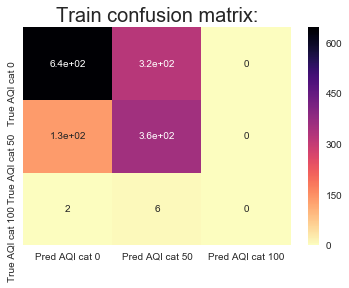

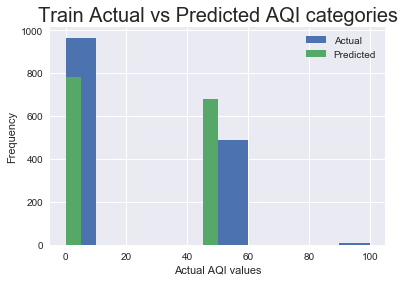

X_test shape: (488, 10)
 ROC AUC: -0.47974875460255584


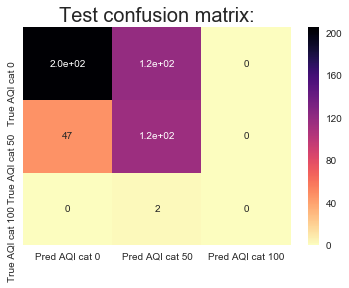

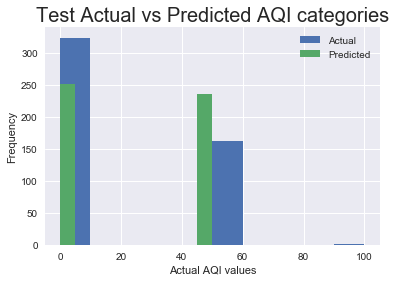

In [199]:
n_closestareas(repareas)